# Test lagged covariance calculation in 3 dimensions ($x-y$ and $t$)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from scipy import signal
from tqdm import tqdm

from oceanoi import cov, oi, variogram

In [2]:
plt.rcParams['pcolor.shading'] = 'auto'

((38, 36, 30), (38,), (36,), (30,))

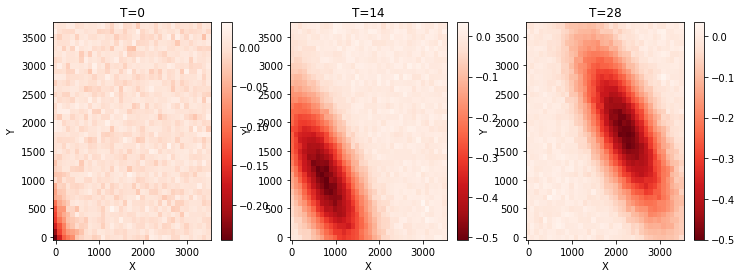

In [3]:
# Create a dataset for a propagating (soliton-like) signal
def rotate_xy_deg(xin, yin, thetadeg):
    theta = np.pi*thetadeg/180
    cost = np.cos(theta)
    sint = np.sin(theta)
    return xin*cost - yin*sint, xin*sint + yin*cost

#####
# parameters
a0=0.5
lx = 1600.
ly = 600.
thetadeg = 60.
c = 1.0
x0 = -500.
y0 = -500.

tmax = 3600.

dx = 100
dt = 120.

######
thetarad = np.pi*thetadeg/180
x = np.arange(0, tmax*c, dx)
y = np.arange(0, tmax*c+2*dx, dx)
t = np.arange(0, tmax, dt)

X,Y,T = np.meshgrid(x,y,t)
Xr, Yr = rotate_xy_deg(X, Y, thetadeg)
cx = c*np.cos(thetarad)
cy = c*np.sin(thetarad)

u = -a0* \
    np.exp( -( (Xr-x0)**2/lx**2 + 
          (Yr-c*T-y0)**2/ly**2 
        ) )\
    + 0.01*np.random.normal(size=X.shape)
    
# u = -a0* \
#     np.exp( -( (X-cx*T-x0)**2/lx**2 + 
#           (Y-cy*T-y0)**2/ly**2 +
#           (X-cx*T-x0)*(Y-cy*T-y0)/(lx*ly*np.cos(thetarad))    
#         ) )\
#     + 0.01*np.random.normal(size=X.shape)
    



plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')
u.shape, y.shape, x.shape, t.shape


CPU times: user 27.3 ms, sys: 11.8 ms, total: 39.1 ms
Wall time: 30 ms


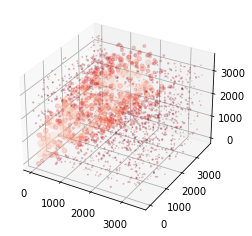

In [4]:
%%time
# Take a random sample of the data for a 2D 
ny,nx,nt = u.shape
nsamples = 2000
rr = np.random.randint(ny,size=nsamples)
cc = np.random.randint(nx,size=nsamples)
ii = np.random.randint(nt,size=nsamples)

xx = X[rr,cc,ii]
yy = Y[rr,cc,ii]
tt = T[rr,cc,ii]

Z = u[rr,cc,ii]

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx,yy,zs=tt,s=np.abs(Z)*100,c=Z, cmap='Reds',alpha=0.2)


In [5]:
nx = xx.shape
xall = np.repeat(xx[:,None],nx,axis=1)
xall.shape

(2000, 2000)

In [6]:
def calc_variogram_3d(X, Y, T, Z, xbins, ybins, tbins):
    """
    Calculate variogram parameters along 3-dimension
    """
    nx = X.shape
    ny = Y.shape
    nt = T.shape
    
    #assert nx == ny, ny == nt

    xall = np.repeat(X[:,None],nx,axis=1)
    yall = np.repeat(Y[:,None],nx,axis=1)
    tall = np.repeat(T[:,None],nt,axis=1)


    xdist = xall - xall.T # Distance between all points in a vector with every other point
    ydist = yall - yall.T # Distance between all points in a vector with every other point
    tdist = tall - tall.T # Distance between all points in a vector with every other point

    hx = 0.5*(xbins[0:-1] + xbins[1:])
    nxbins = hx.shape[0]
    hy = 0.5*(ybins[0:-1] + ybins[1:])
    nybins = hy.shape[0]
    ht = 0.5*(tbins[0:-1] + tbins[1:])
    ntbins = ht.shape[0]

    v = np.zeros((nybins,nxbins,ntbins))
    N = np.zeros((nybins,nxbins,ntbins))
    # Load 
    for ii in range(nxbins):
        print(ii, nxbins)
        for jj in range(nybins):
            for tt in range(ntbins):
                idx = (xdist>=xbins[ii]) & (xdist <=xbins[ii+1]) &\
                    (ydist>=ybins[jj]) & (ydist <=ybins[jj+1]) &\
                    (tdist>=tbins[tt]) & (tdist <=tbins[tt+1]) 
                rc = np.argwhere(idx)
                #print(idx.shape)
                v[jj,ii,tt] = np.sum( np.power(Z[rc[:,0]]-Z[rc[:,1]],2) )
                N[jj,ii,tt] = idx.sum()
    
    return hx, hy, ht, v/(2*N), N

In [7]:
%%time
dx=300
dy=300
dt = 180

xbins = np.arange(-1500,1500+dx,dx)
ybins = np.arange(-1500,1500+dy,dy)
tbins = np.arange(-5*dt,5*dt+dt,dt)

hx, hy, ht, v, N = calc_variogram_3d(xx,yy,tt,Z,xbins,ybins,tbins)
# plt.figure()
# plt.pcolormesh(hx, hy, v)


0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
CPU times: user 37.7 s, sys: 1.77 s, total: 39.5 s
Wall time: 39.7 s


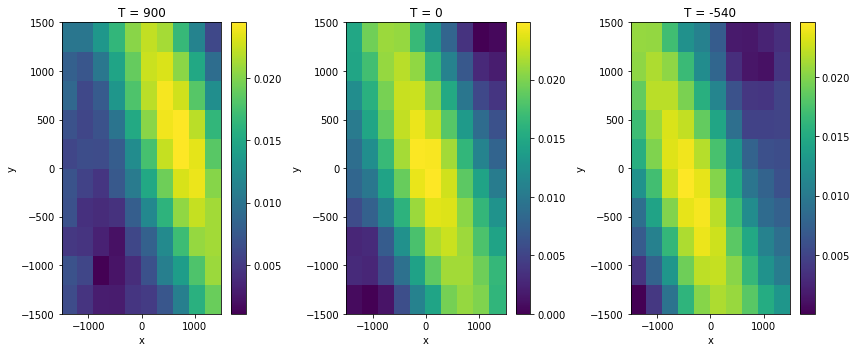

In [138]:
# Plot the covariance along different dimensions
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(hx,hy,v.max()-v[:,:,-1],shading='auto')
plt.title('T = {}'.format(tbins[-1]))
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(132)
plt.pcolormesh(hx,hy,v.max()-v[:,:,5],shading='auto')
plt.title('T = {}'.format(tbins[5]))
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(133)
plt.pcolormesh(hx,hy,v.max()-v[:,:,2],shading='auto')
plt.title('T = {}'.format(tbins[2]))
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.tight_layout()

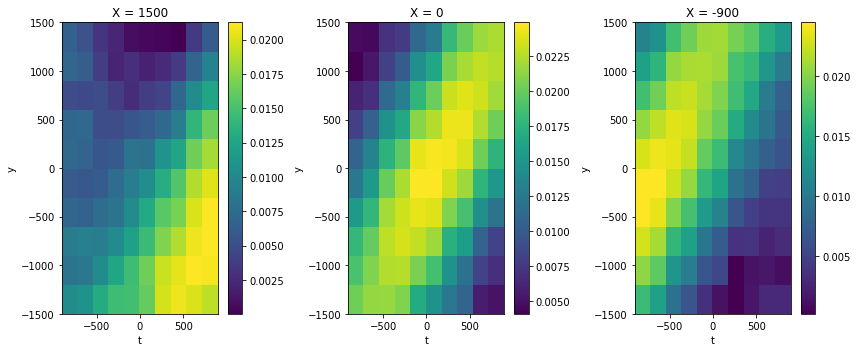

In [139]:
#  Plot the covariance along different dimensions
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.pcolormesh(ht,hy,v.max()-v[:,-1,:],shading='auto')
plt.title('X = {}'.format(xbins[-1]))
plt.colorbar()
plt.ylabel('y')
plt.xlabel('t')

plt.subplot(132)
plt.pcolormesh(ht,hy,v.max()-v[:,5,:],shading='auto')
plt.title('X = {}'.format(xbins[5]))
plt.colorbar()
plt.ylabel('y')
plt.xlabel('t')

plt.subplot(133)
plt.pcolormesh(ht,hy,v.max()-v[:,2,:],shading='auto')
plt.title('X = {}'.format(xbins[2]))
plt.colorbar()
plt.ylabel('y')
plt.xlabel('t')
plt.tight_layout()

In [140]:
def expquad_rotated_cov_3d(X, Y, T, x, y, t, params):
    """
    2D Matern Covariance with rotation
    
    Inputs:
        X,Y,T: matrices or vectors of input points
        x,y,t: matrices or vectors of output points
        params: tuple length 4
            eta: scale
            lx: x length scale
            ly: y length scale
            c: translation speed parallel to the rotated y-direction
            thetadeg: rotation angle (degrees CCW of East)
    """
    eta, lx, ly, c, thetadeg = params

    # Rotate the coordinates
    Xr, Yr = cov.rotate_xy(X,Y, thetadeg)
    xr, yr = cov.rotate_xy(x,y, thetadeg)
    
    # Translate the y-coordinates
    Yt = Yr - c*T
    yt = yr - c*t
    
    # Build the covariance matrix
    C = cov.expquad(Xr,xr,lx) 
    C *= cov.expquad(Yt,yt,ly)

    return eta**2 * C

def expquad_cov_2d(X, Y, T, x, y, t, params):
    """
    2D Exponential Quadratic Covariance with rotation
    
    Inputs:
        X,Y,T: matrices or vectors of input points
        x,y,t: matrices or vectors of output points
        params: tuple length 4
            eta: scale
            lx: x length scale
            ly: y length scale
            c: translation speed parallel to the rotated y-direction
            thetadeg: rotation angle (degrees CCW of East)
    """
    eta, lx, ly,  = params
    
    
    # Build the covariance matrix
    C = expquad(X,x,lx) 
    C *= expquad(Y,y,ly)

    return eta**2 * C

def expquad_cov_3d(X, Y, T, x, y, t, params):
    """
    3D Exponential Quadratic Covariance with rotation
    
    Inputs:
        X,Y,T: matrices or vectors of input points
        x,y,t: matrices or vectors of output points
        params: tuple length 4
            eta: scale
            lx: x length scale
            ly: y length scale
            c: translation speed parallel to the rotated y-direction
            thetadeg: rotation angle (degrees CCW of East)
    """
    eta, lx, ly, lt, lxy, lxt, lyt, xoff, yoff, toff  = params
    #eta, lx, ly, lt, xoff, yoff, toff  = params
    
    # Build the covariance matrix
    C = expquad(X,x+xoff,lx) 
    C *= expquad(Y,y+yoff,ly)
    C *= expquad(T,t+toff,lt)

    # Rotated components
    C *= expquad2(X,Y,x+xoff,y+yoff,lxy)
    C *= expquad2(X,T,x+xoff,t+toff,lxt)
    C *= expquad2(Y,T,y+yoff,t+toff,lyt)

    return eta**2 * C


def expquad(x, xpr, l):
    return np.exp(-(x-xpr)*(x-xpr)/(2*l*l))

def expquad2(x, x2, xpr, xpr2, lxy):
    return np.exp(-(x-xpr)*(x2-xpr2)*lxy)


/home/suntans/code/oceanoi/oceanoi/cov.py:39: OptimizeWarning: Unknown solver options: eps
  soln = minimize(min_covariance_lsq_3d, param_guess,


   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
 

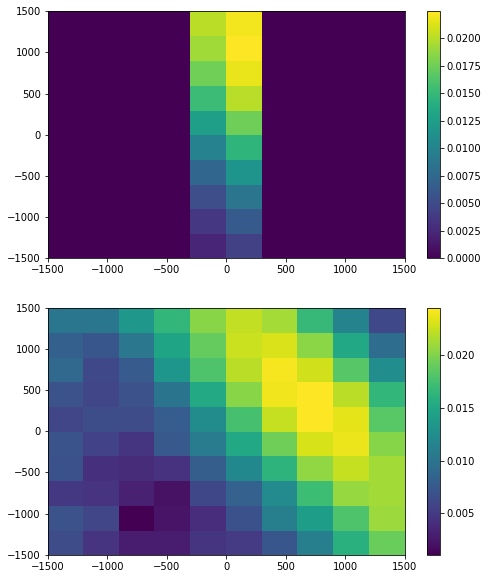

In [141]:
# Fit a covariance model to the data
sill = v.max()
Cxt = sill - v
#Cxt/=sill
Hx, Hy, Ht = np.meshgrid(hx,hy, ht)

scale=1e-3

covfunc = expquad_cov_3d
covparams = (0.01, .1, 1.0, 0.5, 0.,0.,0., 0.,0.,0.)
#covparams = (1., 1100*scale, 1000*scale, 0.5*scale,0.,0.,0.)

#covparams = (1., 1100*scale, 1000*scale, 0.5*scale, 14.)


soln=cov.optimize_covariance_model_3d(covfunc, Hx*scale, Hy*scale, Ht*scale, Cxt, 0.,0.,0., covparams,
                                     method='powell',options={'eps':1e-7})
print(soln)
Cfit = covfunc( Hx*scale, Hy*scale, Ht*scale, 0.,0., 0., soln['x'])

plt.figure(figsize=(8,10))
plt.subplot(211)
plt.pcolormesh(hx,hy,Cfit[:,:,-1], shading='auto')
plt.colorbar()

plt.subplot(212)
plt.pcolormesh(hx,hy,Cxt[:,:,-1], shading='auto')
plt.colorbar()


covparams = soln['x']
#covparams[1] = covparams[1]/scale
#covparams[2] = covparams[2]/scale
print(covparams)



In [142]:
%%time
scale = 1e-3
# Optimal interpolation using scatter data
ny,nx,nt = u.shape
nsamples = 5000
rr = np.random.randint(ny,size=nsamples)
cc = np.random.randint(nx,size=nsamples)
ii = np.random.randint(nt,size=nsamples)

xtest = X[rr,cc,ii]
ytest = Y[rr,cc,ii]
ttest = T[rr,cc,ii]
ztest = u[rr,cc,ii]

U_oi = np.zeros_like(X)
# Loop through each time point (this is purely to avoid a memory blowout)
#for ii in tqdm(range(nt)):
for ii in [0,14,28]:
    print(ii)
    #if ii%20==0:
    #    print(ii, X.shape[0])
        
    Xm = X[:,:,ii]
    Ym = Y[:,:,ii]
    Tm = T[:,:,ii]
    sd = 0.01
    OI = oi.OptimalInterp3D(xtest*scale, ytest*scale, ttest*scale, \
                            Xm.ravel()*scale, Ym.ravel()*scale, Tm.ravel()*scale,\
                            sd, covfunc, covparams)
    U_oi[...,ii] = OI(ztest[:,None]).reshape((ny,nx))

# plt.figure()

0


KeyboardInterrupt: 

Text(0.5, 1.0, 'T=28')

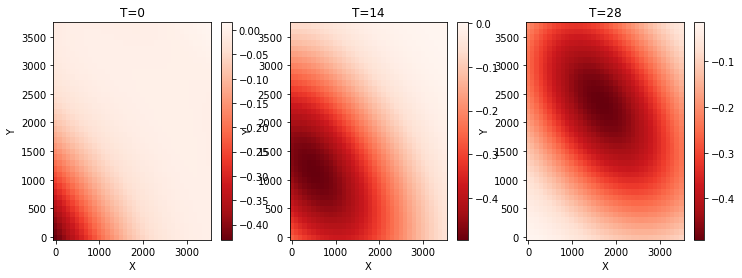

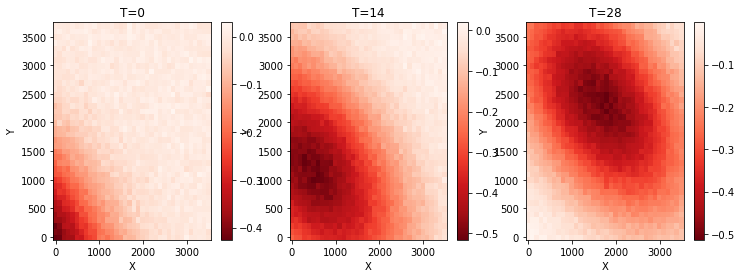

In [95]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],U_oi[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],U_oi[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],U_oi[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')


In [96]:
# %%time
scale = 1e-3
# Optimal interpolation using "time-series" data i.e., from pseudo-moorings
ny,nx,nt = u.shape

# Example set of stations to extract time-series data from
# cc = [10,20,30, 12]
# rr = [5,15,22, 22]
cc = [10,]
rr = [22]

xd = X[rr,cc,:].ravel()
yd = Y[rr,cc,:].ravel()
td = T[rr,cc,:].ravel()
zd = u[rr,cc,:].ravel()

U_oi = np.zeros_like(X)
# Loop through each time point (this is purely to avoid a memory blowout)
#for ii in tqdm(range(nt)):
for ii in [0,14,28]:
    print(ii)
    #if ii%20==0:
    #    print(ii, X.shape[0])
        
    Xm = X[:,:,ii]
    Ym = Y[:,:,ii]
    Tm = T[:,:,ii]
    sd = 0.01
    OI = oi.OptimalInterp3D(xd*scale, yd*scale, td*scale, \
                            Xm.ravel()*scale, Ym.ravel()*scale, Tm.ravel()*scale,\
                            sd, covfunc, covparams)
    U_oi[...,ii] = OI(zd[:,None]).reshape((ny,nx))

# plt.figure()


0
14
28


Text(0.5, 1.0, 'T=28')

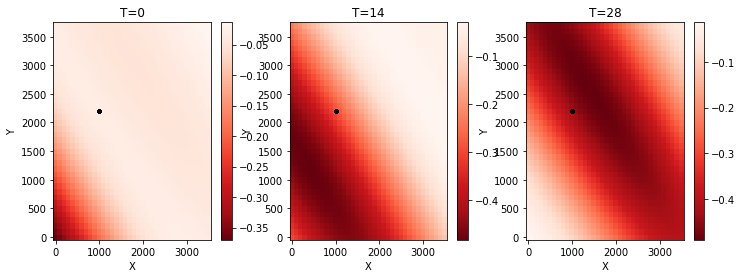

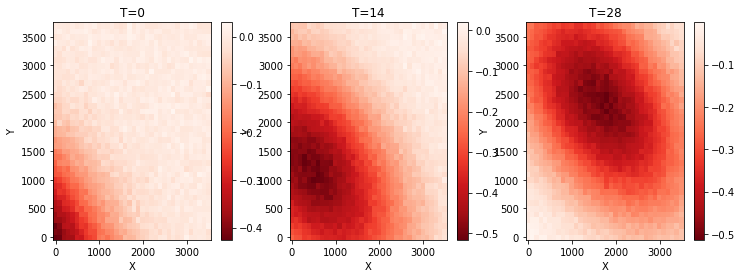

In [97]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],U_oi[:,:,0],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],U_oi[:,:,14],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],U_oi[:,:,28],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')


In [143]:
def rotate_3d(X, Y, T, theta_x, theta_y, theta_t):
    
    if isinstance(X,float):
        XYT = np.array([X, Y, T])
        sz=(1,)
    else:
        XYT = np.array([X.ravel(), Y.ravel(), T.ravel()])
        sz = np.shape(X)

    R1 = np.array([[np.cos(theta_x), -np.sin(theta_x), 0.],
                  [np.sin(theta_x), np.cos(theta_x),0.],
                   [0., 0., 1.]])

    R2 = np.array([[np.cos(theta_y), 0., np.sin(theta_y)],
                   [0, 1., 0.],
                   [-np.sin(theta_y), 0., np.cos(theta_y)]])

    R3 = np.array([[1., 0., 0.],
                   [0., np.cos(theta_t), -np.sin(theta_t)],
                   [0., np.sin(theta_t), np.cos(theta_t)]])

    # N.B. @ is shorthand for np.matmul
    R = R1 @ R2 @ R3

    # Do the rotation
    XYT_r = R @ XYT
    
    if isinstance(X, float):
        xr = XYT_r[0]
        yr = XYT_r[1]
        tr = XYT_r[2]
    else:
        xr = XYT_r[0,:].reshape(sz)
        yr = XYT_r[1,:].reshape(sz)
        tr = XYT_r[2,:].reshape(sz)
    
    return xr, yr, tr

def expquad_cov_3d_r(X, Y, T, x, y, t, params):
    """
    3D Exponential Quadratic Covariance with rotation
    
    Inputs:
        X,Y,T: matrices or vectors of input points
        x,y,t: matrices or vectors of output points
        params: tuple length 4
            eta: scale
            lx: x length scale
            ly: y length scale
            thetadeg: rotation angle (degrees CCW of East)
    """
    eta, lx, ly, lt, theta_x, theta_y, theta_t  = params
    
    Xr, Yr, Tr = rotate_3d(X, Y, T, theta_x, theta_y, theta_t)
    xr, yr, tr = rotate_3d(x, y, t, theta_x, theta_y, theta_t)

    # Build the covariance matrix
    C = expquad(Xr,xr,lx) 
    C *= expquad(Yr,yr,ly)
    C *= expquad(Tr,tr,lt)

    return eta**2 * C


In [144]:
def matern52(x,xpr,l):
    fac1 = 5*(x-xpr)*(x-xpr)
    fac2 = np.sqrt(fac1)
    return (1 + fac2/l + fac1/(3*l*l) )*np.exp(-fac2/l)

def matern52_cov_3d_r(X, Y, T, x, y, t, params):
    """
    3D Exponential Quadratic Covariance with rotation
    
    Inputs:
        X,Y,T: matrices or vectors of input points
        x,y,t: matrices or vectors of output points
        params: tuple length 4
            eta: scale
            lx: x length scale
            ly: y length scale
            thetadeg: rotation angle (degrees CCW of East)
    """
    eta, lx, ly, lt, theta_x, theta_y, theta_t  = params
    
    Xr, Yr, Tr = rotate_3d(X, Y, T, theta_x, theta_y, theta_t)
    xr, yr, tr = rotate_3d(x, y, t, theta_x, theta_y, theta_t)

    # Build the covariance matrix
    C = matern52(Xr,xr,lx) 
    C *= matern52(Yr,yr,ly)
    C *= matern52(Tr,tr,lt)

    return eta**2 * C


   direc: array([[ 1.19990152e-04, -1.32573146e-01, -3.87466880e-01,
        -5.80286662e-04,  3.22776947e-03, -7.29238274e-04,
         1.77565838e-04],
       [ 4.36026949e-05, -1.05013506e-02, -1.66285249e-02,
         1.81107153e-03, -1.65223654e-02,  8.02376999e-04,
        -3.40748904e-03],
       [-1.64210091e-03,  9.99491363e-02,  1.72727781e-02,
        -2.78826084e-02, -1.02063858e-01,  8.63888132e-03,
         1.63170321e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 1.02000262e-04, -2.13128699e-02, -6.10817410e-02,
        -6.10563440e-04,  1.40717523e-03,  4.64881403e-05,
        

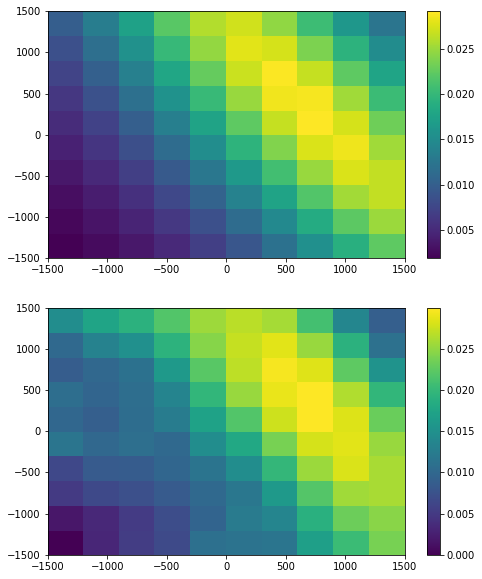

In [12]:
# Fit a covariance model to the data
sill = v.max()
Cxt = sill - v
#Cxt/=sill
Hx, Hy, Ht = np.meshgrid(hx,hy, ht)

scale=1e-3

covfunc = cov.rotated_matern32_cov_3d

covparams = (0.01, .1, 1.0, 0.5, 0.,0.,0.)


soln=cov.optimize_covariance_model_3d(covfunc, Hx*scale, Hy*scale, Ht*scale, Cxt, 0.,0.,0., covparams,
                                     method='powell')
print(soln)
Cfit = covfunc( Hx*scale, Hy*scale, Ht*scale, 0.,0., 0., soln['x'])

plt.figure(figsize=(8,10))
plt.subplot(211)
plt.pcolormesh(hx,hy,Cfit[:,:,-1], shading='auto')
plt.colorbar()

plt.subplot(212)
plt.pcolormesh(hx,hy,Cxt[:,:,-1], shading='auto')
plt.colorbar()


In [19]:
%%time
scale = 1e-3
# Optimal interpolation using scatter data
ny,nx,nt = u.shape
nsamples = 5000
rr = np.random.randint(ny,size=nsamples)
cc = np.random.randint(nx,size=nsamples)
ii = np.random.randint(nt,size=nsamples)

xtest = X[rr,cc,ii]
ytest = Y[rr,cc,ii]
ttest = T[rr,cc,ii]
ztest = u[rr,cc,ii]

# # Example set of stations to extract time-series data from
# # cc = [10,20,30, 12]
# # rr = [5,15,22, 22]
# cc = [10,23]
# rr = [22,35]

# xtest = X[rr,cc,:]
# ytest = Y[rr,cc,:]
# ttest = T[rr,cc,:]
# ztest = u[rr,cc,:]

U_oi = np.zeros_like(X)
# Loop through each time point (this is purely to avoid a memory blowout)
#for ii in tqdm(range(nt)):
for ii in [0,14,28]:
    print(ii)
    #if ii%20==0:
    #    print(ii, X.shape[0])
        
    Xm = X[:,:,ii]
    Ym = Y[:,:,ii]
    Tm = T[:,:,ii]
    sd = 0.01
    OI = oi.OptimalInterp3D(xtest*scale, ytest*scale, ttest*scale, \
                            Xm.ravel()*scale, Ym.ravel()*scale, Tm.ravel()*scale,\
                            sd, covfunc, soln['x'])
    U_oi[...,ii] = OI(ztest[:,None]).reshape((ny,nx))

# plt.figure()

0
14
28
CPU times: user 37.8 s, sys: 3.71 s, total: 41.5 s
Wall time: 18.7 s


Text(0.5, 1.0, 'T=28')

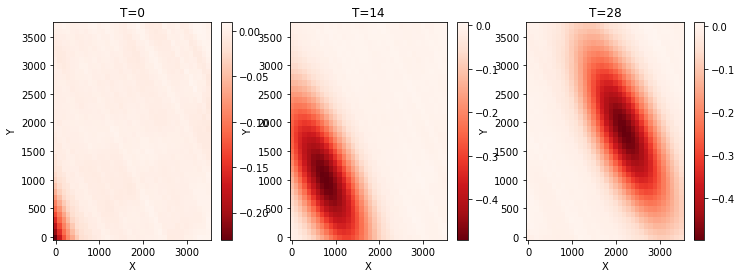

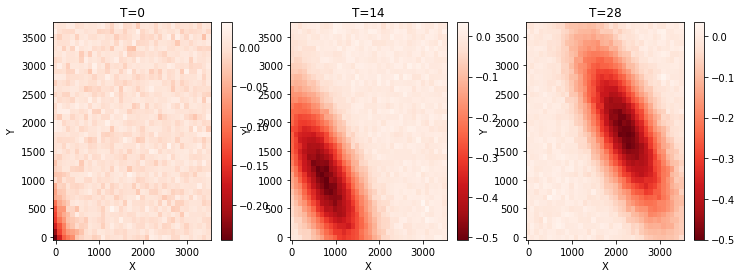

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],U_oi[:,:,0],cmap='Reds_r', shading='auto')
# plt.plot(xtest,ytest,'k.')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],U_oi[:,:,14],cmap='Reds_r', shading='auto')
# plt.plot(xtest,ytest,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],U_oi[:,:,28],cmap='Reds_r', shading='auto')
# plt.plot(xtest,ytest,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')


In [16]:
# %%time
scale = 1e-3
# Optimal interpolation using "time-series" data i.e., from pseudo-moorings
ny,nx,nt = u.shape

# Example set of stations to extract time-series data from
# cc = [10,20,30, 12]
# rr = [5,15,22, 22]
cc = [10,22]
rr = [22, 15]

xd = X[rr,cc,:].ravel()
yd = Y[rr,cc,:].ravel()
td = T[rr,cc,:].ravel()
zd = u[rr,cc,:].ravel()

U_oi = np.zeros_like(X)
# Loop through each time point (this is purely to avoid a memory blowout)
#for ii in tqdm(range(nt)):
for ii in [0,14,28]:
    print(ii)
    #if ii%20==0:
    #    print(ii, X.shape[0])
        
    Xm = X[:,:,ii]
    Ym = Y[:,:,ii]
    Tm = T[:,:,ii]
    sd = 0.01
    OI = oi.OptimalInterp3D(xd*scale, yd*scale, td*scale, \
                            Xm.ravel()*scale, Ym.ravel()*scale, Tm.ravel()*scale,\
                            sd, covfunc, soln['x'])
    U_oi[...,ii] = OI(zd[:,None]).reshape((ny,nx))

# plt.figure()


0
14
28


Text(0.5, 1.0, 'T=28')

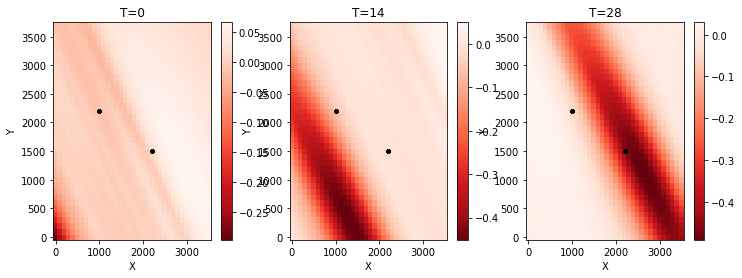

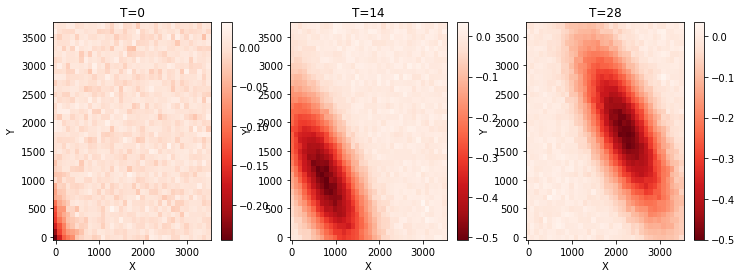

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],U_oi[:,:,0],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],U_oi[:,:,14],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],U_oi[:,:,28],cmap='Reds_r', shading='auto')
plt.plot(xd,yd,'k.')

plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(X[:,:,0],Y[:,:,0],u[:,:,0],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=0')

plt.subplot(132)
plt.pcolormesh(X[:,:,14],Y[:,:,14],u[:,:,14],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=14')


plt.subplot(133)
plt.pcolormesh(X[:,:,28],Y[:,:,28],u[:,:,28],cmap='Reds_r', shading='auto')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('T=28')
